<a href="https://colab.research.google.com/github/nikhitha2201/TrimGalore/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT : Amyotrophic Lateral Sclerosis detection from GWAS data using KG, GNN and LLMs

## Importing Libraries

In [110]:
# Install PyTorch Geometric and dependencies
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [111]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu117.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html


In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import f1_score, accuracy_score
import numpy as np


## Reading Data

In [113]:
import torch

# Load the full object (only if you trust the source!)
dataset_path = '02-alzheimers-parkinson_disease-amyotrophic_lateral_sclerosis.pth'
graph_data = torch.load(dataset_path, map_location='cpu', weights_only=False)

# Check its structure
print("Type:", type(graph_data))
if hasattr(graph_data, '__dict__'):
    print("Attributes:", vars(graph_data).keys())
elif isinstance(graph_data, dict):
    print("Keys:", graph_data.keys())


Type: <class 'torch_geometric.data.data.Data'>
Attributes: dict_keys(['_edge_attr_cls', '_tensor_attr_cls', '_store'])


In [114]:
print("Keys:", graph_data.keys())

Keys: ['disease_mapping', 'edge_index', 'node_labels', 'edge_attr', 'train_mask', 'y', 'x', 'test_mask']


In [115]:
len(graph_data.edge_attr)

3222

In [116]:
len(graph_data.y)

3222

## GNN(GRAPH NEURAL NETWORK)

In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNN(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        # First GCN layer: input node features to hidden channels
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)  # BatchNorm after conv1

        # Second GCN layer: hidden channels to twice hidden channels
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.bn2 = nn.BatchNorm1d(hidden_channels * 2)  # BatchNorm after conv2

        # Third GCN layer: downsample back to hidden channels
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels)
        self.bn3 = nn.BatchNorm1d(hidden_channels)  # BatchNorm after conv3

        # Linear layer to predict the final classes
        self.lin = nn.Linear(hidden_channels * 2, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

        # Multihead Attention layer to capture richer node interactions
        self.attention = nn.MultiheadAttention(embed_dim=hidden_channels, num_heads=4)

    def forward(self, x, edge_index, edge_attr):
        """
        Forward pass of the GNN model.

        Args:
            x (Tensor): Node feature matrix of shape [num_nodes, num_node_features].
            edge_index (LongTensor): Graph connectivity in COO format with shape [2, num_edges].
            edge_attr (Tensor): Edge features (not directly used in this model).

        Returns:
            Tensor: Log-probabilities for each edge (source, destination) pair,
                    with shape [num_edges, num_classes].
        """

        # Ensure x has a channel dimension (batch size 1) and is float type
        x = x.unsqueeze(1).float()

        # First GCN + BatchNorm + Activation + Dropout
        x1 = F.leaky_relu(self.bn1(self.conv1(x, edge_index)))
        x1 = self.dropout(x1)

        # Second GCN + BatchNorm + Activation + Dropout
        x2 = F.leaky_relu(self.bn2(self.conv2(x1, edge_index)))
        x2 = self.dropout(x2)

        # Third GCN + skip connection + BatchNorm + Activation
        x3 = F.leaky_relu(self.bn3(self.conv3(x2, edge_index) + x1))

        # Apply multihead attention over node features
        x3, _ = self.attention(x3.unsqueeze(0), x3.unsqueeze(0), x3.unsqueeze(0))
        x3 = x3.squeeze(0)  # Remove the batch dimension

        # Get source and destination nodes for each edge
        src, dst = edge_index

        # Concatenate the features of source and destination nodes for each edge
        edge_features = torch.cat([x3[src], x3[dst]], dim=1)

        # Final linear layer followed by log_softmax for classification
        return F.log_softmax(self.lin(edge_features), dim=-1)


In [118]:

def evaluate_f1(model, data, mask):
    """
    Evaluate the model's performance using accuracy and F1 scores.

    Args:
        model (nn.Module): The trained GNN model to evaluate.
        data (Data): A PyTorch Geometric data object containing graph information
                     (x: node features, edge_index: edges, edge_attr: edge features, y: labels).
        mask (BoolTensor): A boolean mask indicating which nodes/edges to evaluate
                           (e.g., train/validation/test split).

    Returns:
        tuple:
            - accuracy (float): Classification accuracy on the masked data.
            - f1_macro (float): Macro-averaged F1 score (treats all classes equally).
            - f1_weighted (float): Weighted-averaged F1 score (accounts for class imbalance).
    """

    model.eval()  # Set model to evaluation mode (deactivates dropout, etc.)

    with torch.no_grad():  # No gradients needed during evaluation
        # Forward pass to get model outputs
        out = model(data.x, data.edge_index, data.edge_attr)

        # Get predicted class labels
        pred = out.argmax(dim=-1)

        # Extract the true labels and predicted labels for the given mask
        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()

        # Compute evaluation metrics
        accuracy = accuracy_score(y_true, y_pred)             # Simple accuracy
        f1_macro = f1_score(y_true, y_pred, average='macro')   # F1 score treating all classes equally
        f1_weighted = f1_score(y_true, y_pred, average='weighted')  # F1 score weighted by support (class size)

        return accuracy, f1_macro, f1_weighted


In [119]:


# Set the device: use GPU if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move graph data tensors to the selected device (CPU or GPU)
graph_data.x = graph_data.x.float().to(device)         # Node features
graph_data.edge_index = graph_data.edge_index.to(device)  # Edge connections
graph_data.edge_attr = graph_data.edge_attr.to(device)    # Edge attributes
graph_data.y = graph_data.y.to(device)                # Labels
graph_data.train_mask = graph_data.train_mask.to(device)  # Mask for training nodes
graph_data.test_mask = graph_data.test_mask.to(device)    # Mask for test nodes

# Initialize the GNN model and move it to the device
model = GNN(
    num_node_features=1,  # Number of input features per node
    hidden_channels=128,  # Size of hidden layers
    num_classes=len(torch.unique(graph_data.y))  # Number of classes for classification
).to(device)


In [120]:
# Class weights
unique_classes, class_counts = torch.unique(graph_data.y, return_counts=True)
class_weights = (1. / class_counts.float()).to(device)
print(f"Class Distribution: {dict(zip(unique_classes.tolist(), class_counts.tolist()))}")

# Shuffle edges for training randomness
num_edges = graph_data.edge_index.size(1)
shuffled_indices = torch.randperm(num_edges)
graph_data.edge_index = graph_data.edge_index[:, shuffled_indices]
graph_data.edge_attr = graph_data.edge_attr[shuffled_indices]
graph_data.y = graph_data.y[shuffled_indices]

Class Distribution: {0: 2383, 1: 181, 2: 658}


In [121]:
# Optimizer and loss
optimizer = torch.optim.AdamW([
    {'params': model.conv1.parameters(), 'weight_decay': 1e-4},
    {'params': model.conv2.parameters(), 'weight_decay': 1e-4},
    {'params': model.conv3.parameters()},
    {'params': model.lin.parameters(), 'weight_decay': 1e-4}
], lr=0.0003)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [122]:
# Set number of training epochs
epochs = 300

print("Training started...")

# Lists to store training and validation metrics for plotting
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()  # Set model to training mode

    optimizer.zero_grad()  # Reset gradients to zero before each step

    # Forward pass
    out = model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)

    # Calculate loss only on the training nodes
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])

    # Backward pass
    loss.backward()

    # Clip gradients to avoid exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.5)

    # Optimizer step (update model parameters)
    optimizer.step()

    # Every 5 epochs, evaluate and print training metrics
    if (epoch + 1) % 5 == 0:
        # Evaluate model on training data
        train_acc, train_f1_macro, train_f1_weighted = evaluate_f1(model, graph_data, graph_data.train_mask)

        # Evaluate model on validation/test data
        val_acc, val_f1_macro, val_f1_weighted = evaluate_f1(model, graph_data, graph_data.test_mask)

        # Store accuracies for plotting
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'\nEpoch {epoch+1:03d}:')
        print(f'Train Loss: {loss.item():.4f}')
        print(f'Train Accuracy: {train_acc:.4f} | Macro F1: {train_f1_macro:.4f} | Weighted F1: {train_f1_weighted:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f} | Macro F1: {val_f1_macro:.4f} | Weighted F1: {val_f1_weighted:.4f}')


Training started...

Epoch 005:
Train Loss: 1.0618
Train Accuracy: 0.4703 | Macro F1: 0.2939 | Weighted F1: 0.5391
Validation Accuracy: 0.4636 | Macro F1: 0.2959 | Weighted F1: 0.5263

Epoch 010:
Train Loss: 0.9270
Train Accuracy: 0.4649 | Macro F1: 0.2943 | Weighted F1: 0.5366
Validation Accuracy: 0.4465 | Macro F1: 0.2889 | Weighted F1: 0.5158

Epoch 015:
Train Loss: 0.8195
Train Accuracy: 0.5297 | Macro F1: 0.3267 | Weighted F1: 0.5890
Validation Accuracy: 0.5194 | Macro F1: 0.3265 | Weighted F1: 0.5758

Epoch 020:
Train Loss: 0.7293
Train Accuracy: 0.5770 | Macro F1: 0.3592 | Weighted F1: 0.6263
Validation Accuracy: 0.5736 | Macro F1: 0.3608 | Weighted F1: 0.6185

Epoch 025:
Train Loss: 0.6782
Train Accuracy: 0.6729 | Macro F1: 0.5017 | Weighted F1: 0.7262
Validation Accuracy: 0.6791 | Macro F1: 0.5226 | Weighted F1: 0.7344

Epoch 030:
Train Loss: 0.6138
Train Accuracy: 0.7303 | Macro F1: 0.5737 | Weighted F1: 0.7775
Validation Accuracy: 0.7318 | Macro F1: 0.5873 | Weighted F1: 0.7

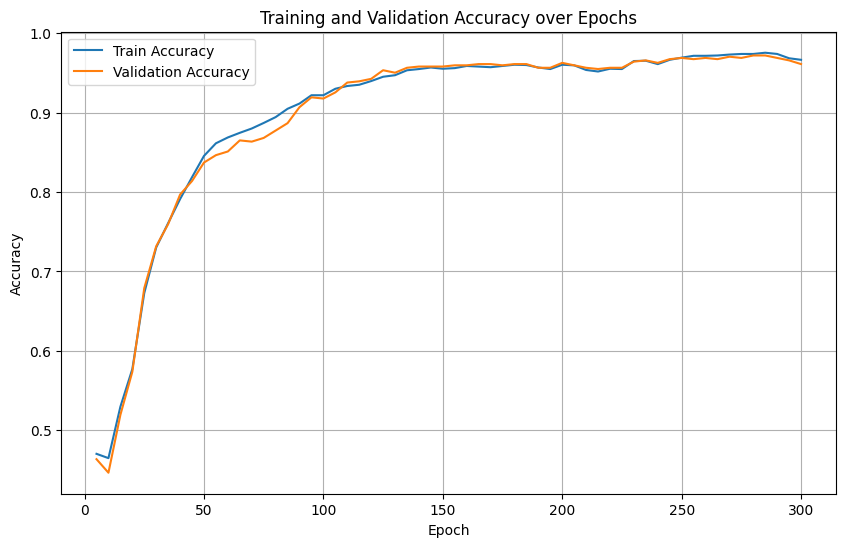

In [123]:
import matplotlib.pyplot as plt

# Create a list of epoch numbers (every 5th epoch because we evaluate every 5 epochs)
epochs_list = list(range(5, epochs + 1, 5))

# Plotting
plt.figure(figsize=(10,6))
plt.plot(epochs_list, train_accuracies, label='Train Accuracy')
plt.plot(epochs_list, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [124]:
# Evaluate the trained model on the test set
test_acc, test_f1_macro, test_f1_weighted = evaluate_f1(model, graph_data, graph_data.test_mask)
print("\nFinal Test Results:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1: {test_f1_macro:.4f}")
print(f"Test Weighted F1: {test_f1_weighted:.4f}")


Final Test Results:
Test Accuracy: 0.9612
Test Macro F1: 0.9099
Test Weighted F1: 0.9611


## MGPOOL(Module-based Graph Pooling)

In [125]:
from torch_geometric.nn import GCNConv, GINConv
import torch.nn.functional as F
import torch.nn as nn
import torch

class MGPOOL(nn.Module):
    """
    MGPOOL: A hybrid GNN model combining GCN and GIN branches with Multi-head Attention.

    Args:
        num_node_features (int): Number of features per node.
        hidden_channels (int): Number of hidden channels for GCN and GIN layers.
        num_classes (int): Number of output classes (for classification).

    Returns:
        nn.Module: A GNN model combining GCN, GIN, and attention-based aggregation.
    """
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()

        # GCN branch: 2-layer GCN with BatchNorm
        self.gcn1 = GCNConv(num_node_features, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        # GIN branch: 2-layer GIN with MLP and BatchNorm
        nn_gin = nn.Sequential(
            nn.Linear(num_node_features, hidden_channels), nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.gin1 = GINConv(nn_gin)

        nn_gin2 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels), nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.gin2 = GINConv(nn_gin2)

        # Batch normalization layers for GCN and GIN outputs
        self.bn_gcn = nn.BatchNorm1d(hidden_channels)
        self.bn_gin = nn.BatchNorm1d(hidden_channels)

        # Multi-head self-attention (input dim = GCN + GIN)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_channels * 2, num_heads=4)

        # Final classifier: after combining edge features from attention output
        self.lin = nn.Linear(hidden_channels * 4, num_classes)  # [src||dst] features
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_attr):
        """
        Forward pass of MGPOOL model.

        Args:
            x (Tensor): Node features of shape [num_nodes, num_node_features].
            edge_index (LongTensor): Edge list in COO format, shape [2, num_edges].
            edge_attr (Tensor): Optional edge attributes (not used in this model).

        Returns:
            Tensor: Log probabilities for each edge, shape [num_edges, num_classes].
        """
        # Ensure input x has a feature dimension (add dummy channel if needed)
        x = x.unsqueeze(1).float()  # [num_nodes, 1, features]

        # ===== GCN branch =====
        gcn_out = self.gcn1(x, edge_index)  # First GCN layer
        gcn_out = self.bn_gcn(F.relu(gcn_out))  # BatchNorm + ReLU
        gcn_out = self.gcn2(gcn_out, edge_index)  # Second GCN layer

        # ===== GIN branch =====
        gin_out = self.gin1(x, edge_index)  # First GIN layer
        gin_out = self.bn_gin(F.relu(gin_out))  # BatchNorm + ReLU
        gin_out = self.gin2(gin_out, edge_index)  # Second GIN layer

        # ===== Combine outputs =====
        x_combined = torch.cat([gcn_out, gin_out], dim=1)  # [num_nodes, hidden_channels * 2]

        # ===== Self-attention over node embeddings =====
        x_attn, _ = self.attention(
            x_combined.unsqueeze(0),  # query
            x_combined.unsqueeze(0),  # key
            x_combined.unsqueeze(0)   # value
        )
        x_attn = x_attn.squeeze(0)  # Remove batch dimension
        x_attn = self.dropout(x_attn)  # Apply dropout

        # ===== Edge-based feature construction =====
        src, dst = edge_index  # Get source and destination node indices for each edge

        # Concatenate source and destination node embeddings to form edge features
        edge_features = torch.cat([x_attn[src], x_attn[dst]], dim=1)  # [num_edges, hidden_channels * 4]

        # ===== Final prediction =====
        return F.log_softmax(self.lin(edge_features), dim=-1)  # [num_edges, num_classes]


In [126]:

# Initialize the MGPOOL model and move it to the device
model = MGPOOL(
    num_node_features=1,
    hidden_channels=128,
    num_classes=len(torch.unique(graph_data.y))
).to(device)


In [127]:
# Optimizer and loss
optimizer = torch.optim.AdamW([
    {'params': model.gcn1.parameters(), 'weight_decay': 1e-4},
    {'params': model.gcn2.parameters(), 'weight_decay': 1e-4},
    {'params': model.gin1.parameters(), 'weight_decay': 1e-4},
    {'params': model.gin2.parameters(), 'weight_decay': 1e-4},
    {'params': model.lin.parameters(), 'weight_decay': 1e-4}
], lr=0.0003)

criterion = nn.CrossEntropyLoss(weight=class_weights)


In [128]:
epochs = 150
print("Training started...")

# Lists to store metrics for plotting
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)

    # Compute training loss
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])

    # Backward pass
    loss.backward()

    # Clip gradients to avoid exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.5)

    # Update model parameters
    optimizer.step()

    # Every 5 epochs, evaluate and print stats
    if (epoch + 1) % 5 == 0:
        # Evaluate on training set
        train_acc, train_f1_macro, train_f1_weighted = evaluate_f1(model, graph_data, graph_data.train_mask)

        # Evaluate on validation set
        val_acc, val_f1_macro, val_f1_weighted = evaluate_f1(model, graph_data, graph_data.test_mask)

        # Store accuracies for plotting
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'\nEpoch {epoch+1:03d}:')
        print(f'Train Loss: {loss.item():.4f}')
        print(f'Train Accuracy: {train_acc:.4f} | Macro F1: {train_f1_macro:.4f} | Weighted F1: {train_f1_weighted:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f} | Macro F1: {val_f1_macro:.4f} | Weighted F1: {val_f1_weighted:.4f}')



Training started...

Epoch 005:
Train Loss: 0.9093
Train Accuracy: 0.2332 | Macro F1: 0.1709 | Weighted F1: 0.2932
Validation Accuracy: 0.2295 | Macro F1: 0.1704 | Weighted F1: 0.2849

Epoch 010:
Train Loss: 0.7984
Train Accuracy: 0.4734 | Macro F1: 0.3020 | Weighted F1: 0.5451
Validation Accuracy: 0.4589 | Macro F1: 0.2993 | Weighted F1: 0.5282

Epoch 015:
Train Loss: 0.7391
Train Accuracy: 0.6131 | Macro F1: 0.3603 | Weighted F1: 0.6475
Validation Accuracy: 0.6078 | Macro F1: 0.3616 | Weighted F1: 0.6358

Epoch 020:
Train Loss: 0.6775
Train Accuracy: 0.6488 | Macro F1: 0.3972 | Weighted F1: 0.6803
Validation Accuracy: 0.6543 | Macro F1: 0.4132 | Weighted F1: 0.6815

Epoch 025:
Train Loss: 0.6381
Train Accuracy: 0.6329 | Macro F1: 0.4060 | Weighted F1: 0.6737
Validation Accuracy: 0.6450 | Macro F1: 0.4303 | Weighted F1: 0.6819

Epoch 030:
Train Loss: 0.6033
Train Accuracy: 0.7268 | Macro F1: 0.4986 | Weighted F1: 0.7520
Validation Accuracy: 0.7194 | Macro F1: 0.5069 | Weighted F1: 0.7

Text(0, 0.5, 'Accuracy')

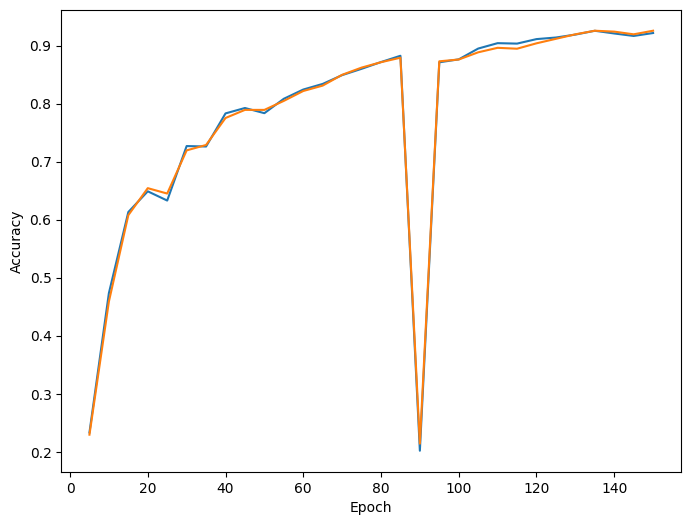

In [129]:

# Plotting accuracy curves
epochs_list = list(range(5, epochs + 1, 5))  # Plot points every 5 epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs_list, train_accuracies, label='Train Accuracy')
plt.plot(epochs_list, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [130]:
test_acc, test_f1_macro, test_f1_weighted = evaluate_f1(model, graph_data, graph_data.test_mask)
print("\nFinal Test Results:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1: {test_f1_macro:.4f}")
print(f"Test Weighted F1: {test_f1_weighted:.4f}")


Final Test Results:
Test Accuracy: 0.9256
Test Macro F1: 0.8755
Test Weighted F1: 0.9279


## Large Language Model-LLM(gpt2)

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from torch_geometric.nn import GCNConv

class GPT2Block(nn.Module):
    """
    A single GPT-2 style Transformer block consisting of:
    - LayerNorm
    - Multihead Self-Attention
    - Feed-Forward Neural Network
    - Residual Connections

    Args:
        hidden_dim (int): Dimension of the hidden representations.
        num_heads (int): Number of attention heads.
        dropout (float): Dropout probability.
    """
    def __init__(self, hidden_dim, num_heads, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        """
        Forward pass through the Transformer block.

        Args:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, hidden_dim).

        Returns:
            Tensor: Output tensor of the same shape as input.
        """
        # Self-attention block
        x_norm = self.ln1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + self.dropout1(attn_out)  # Residual connection

        # Feed-forward block
        x = x + self.mlp(self.ln2(x))    # Residual connection
        return x


class GPT2Graph(nn.Module):
    """
    GPT-2 style Graph Neural Network model.

    This model:
    - Encodes node features using a small GCN layer.
    - Forms edge features by concatenating source and destination node embeddings.
    - Processes edge features through multiple GPT-2 Transformer blocks.
    - Outputs class probabilities for each edge.

    Args:
        num_node_features (int): Number of input node features.
        hidden_dim (int): Dimension of hidden representations inside Transformer.
        num_classes (int): Number of output classes.
        num_layers (int): Number of Transformer blocks.
        num_heads (int): Number of attention heads in each block.
    """
    def __init__(self, num_node_features, hidden_dim, num_classes, num_layers=4, num_heads=4):
        super().__init__()
        self.encoder = nn.Linear(num_node_features, hidden_dim)  # Project edge features to hidden_dim
        self.transformer_blocks = nn.ModuleList([
            GPT2Block(hidden_dim, num_heads) for _ in range(num_layers)
        ])
        self.gcn = GCNConv(1, 1)  # GCN layer for simple initial neighborhood aggregation
        self.ln_f = nn.LayerNorm(hidden_dim)  # Final LayerNorm
        self.head = nn.Linear(hidden_dim, num_classes)  # Final classification head

    def forward(self, x, edge_index, edge_attr):
        """
        Forward pass of GPT2Graph.

        Args:
            x (Tensor): Node features of shape (num_nodes, num_node_features).
            edge_index (Tensor): Edge list tensor with shape (2, num_edges).
            edge_attr (Tensor): Edge attributes (currently unused).

        Returns:
            Tensor: Log-probabilities over classes for each edge (num_edges, num_classes).
        """
        # Prepare node features
        x = x.unsqueeze(1).float()  # shape: [N, 1, F]

        # Preprocess node features using GCN
        x = self.gcn(x.squeeze(1), edge_index).unsqueeze(1)  # shape: [N, 1, F]

        # Form edge features by concatenating src and dst node embeddings
        src, dst = edge_index
        edge_features = torch.cat([x.squeeze(1)[src], x.squeeze(1)[dst]], dim=-1)  # [E, 2F]

        # Project edge features to hidden dimension
        h = self.encoder(edge_features)  # shape: [E, hidden_dim]
        h = h.unsqueeze(0)  # Add batch dimension for Transformer: [1, E, hidden_dim]

        # Pass through stacked Transformer blocks
        for block in self.transformer_blocks:
            h = block(h)

        # Final normalization and classification
        h = self.ln_f(h)
        logits = self.head(h.squeeze(0))  # [E, num_classes]

        # Return log-softmax probabilities
        return F.log_softmax(logits, dim=-1)


In [132]:
# Initialize the GPT2Graph model with specified hyperparameters
model = GPT2Graph(
    num_node_features=2,
    hidden_dim=128,
    num_classes=len(torch.unique(graph_data.y)),
    num_layers=4,
    num_heads=4
).to(device)

In [133]:
# Optimizer and loss
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0003,
    weight_decay=1e-4
)

criterion = nn.CrossEntropyLoss(weight=class_weights)


In [134]:
# Reshape node features to ensure each node has 1 feature dimension
graph_data.x = graph_data.x.view(-1, 1)

# Set number of training epochs
epochs = 300
print("Training started...")

# Lists to store metrics for plotting
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear gradients from the previous step

    # Forward pass: Model output for all edges
    out = model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)

    # Compute training loss only on the nodes indicated by train_mask
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])

    # Backward pass: Compute gradients
    loss.backward()

    # Gradient clipping to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.5)

    # Optimizer step: update model parameters
    optimizer.step()

    # Every 5 epochs, evaluate and print metrics
    if (epoch + 1) % 5 == 0:
        # Evaluate model performance on training data
        train_acc, train_f1_macro, train_f1_weighted = evaluate_f1(model, graph_data, graph_data.train_mask)

        # Evaluate model performance on validation/test data
        val_acc, val_f1_macro, val_f1_weighted = evaluate_f1(model, graph_data, graph_data.test_mask)

        # Save metrics for plotting later
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print current epoch metrics
        print(f'\nEpoch {epoch+1:03d}:')
        print(f'Train Loss: {loss.item():.4f}')
        print(f'Train Accuracy: {train_acc:.4f} | Macro F1: {train_f1_macro:.4f} | Weighted F1: {train_f1_weighted:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f} | Macro F1: {val_f1_macro:.4f} | Weighted F1: {val_f1_weighted:.4f}')




Training started...

Epoch 005:
Train Loss: 1.1210
Train Accuracy: 0.7431 | Macro F1: 0.3059 | Weighted F1: 0.6366
Validation Accuracy: 0.7271 | Macro F1: 0.2814 | Weighted F1: 0.6152

Epoch 010:
Train Loss: 1.0817
Train Accuracy: 0.7373 | Macro F1: 0.4060 | Weighted F1: 0.6867
Validation Accuracy: 0.7194 | Macro F1: 0.3969 | Weighted F1: 0.6667

Epoch 015:
Train Loss: 1.0621
Train Accuracy: 0.5871 | Macro F1: 0.3370 | Weighted F1: 0.6053
Validation Accuracy: 0.5597 | Macro F1: 0.3240 | Weighted F1: 0.5777

Epoch 020:
Train Loss: 1.0535
Train Accuracy: 0.1315 | Macro F1: 0.1667 | Weighted F1: 0.0564
Validation Accuracy: 0.1380 | Macro F1: 0.1671 | Weighted F1: 0.0591

Epoch 025:
Train Loss: 1.0441
Train Accuracy: 0.2371 | Macro F1: 0.2604 | Weighted F1: 0.2399
Validation Accuracy: 0.2403 | Macro F1: 0.2595 | Weighted F1: 0.2396

Epoch 030:
Train Loss: 1.0314
Train Accuracy: 0.4719 | Macro F1: 0.3775 | Weighted F1: 0.5452
Validation Accuracy: 0.4403 | Macro F1: 0.3603 | Weighted F1: 0.5

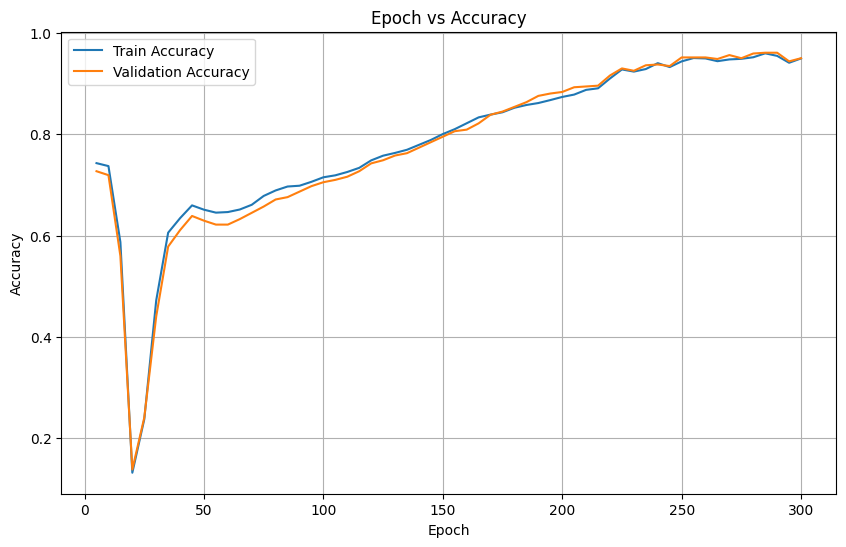

In [135]:
# Plot Epoch vs Accuracy for both Train and Validation


epochs_list = list(range(5, epochs + 1, 5))  # because we log every 5 epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs_list, train_accuracies, label='Train Accuracy')
plt.plot(epochs_list, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [136]:
test_acc, test_f1_macro, test_f1_weighted = evaluate_f1(model, graph_data, graph_data.test_mask)
print("\nFinal Test Results:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1: {test_f1_macro:.4f}")
print(f"Test Weighted F1: {test_f1_weighted:.4f}")


Final Test Results:
Test Accuracy: 0.9504
Test Macro F1: 0.8814
Test Weighted F1: 0.9524


## PRGNN (proximity with relational graph neural network )

In [137]:
class DeepEBlock(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_drop=0.4, layers=2, identity_drop=0.0):
        """
        DeepEBlock: A residual MLP block with optional dimension mapping.

        Args:
            input_dim (int): Dimension of the input features.
            output_dim (int): Dimension of the output features.
            hidden_drop (float): Dropout probability applied after hidden layers.
            layers (int): Number of layers in the residual block.
            identity_drop (float): Optional dropout on identity path.
        """
        super(DeepEBlock, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_drop = nn.Dropout(hidden_drop)
        self.final_bn = nn.BatchNorm1d(output_dim)
        self.identity_bn = nn.BatchNorm1d(output_dim)
        self.identity_drop = nn.Dropout(identity_drop) if identity_drop > 0 else None
        self.activation = nn.ReLU()

        # Create the first layer
        self.reslayer = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            self.hidden_drop,
            nn.ReLU()
        )

        # Add additional hidden layers
        for i in range(layers - 1):
            self.reslayer.append(nn.Linear(output_dim, output_dim))
            self.reslayer.append(nn.BatchNorm1d(output_dim))
            self.reslayer.append(self.hidden_drop)
            if i != layers - 2:
                self.reslayer.append(nn.ReLU())  # ReLU except for the last hidden layer

        # Optional dimension mapping if input and output dims differ
        if input_dim != output_dim:
            self.dim_map = nn.Linear(input_dim, output_dim)
        else:
            self.dim_map = None

    def forward(self, x):
        """
        Forward pass for DeepEBlock.

        Args:
            x (Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            Tensor: Output tensor of shape (batch_size, output_dim).
        """
        if self.dim_map:
            identity = self.dim_map(x)
            identity = self.hidden_drop(identity)
            identity = self.identity_bn(identity)
        else:
            identity = x
            if self.identity_drop:
                identity = self.identity_drop(identity)

        x = self.reslayer(x)
        x = x + identity  # Residual connection
        x = self.final_bn(x)
        return x


class RelationalProximityGNN(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, num_relations):
        """
        RelationalProximityGNN: Combines GCN layers, proximity modeling, and attention for link prediction.

        Args:
            num_node_features (int): Number of input node features.
            hidden_channels (int): Hidden dimension size.
            num_classes (int): Number of output classes.
            num_relations (int): Number of relation types (for embedding edges).
        """
        super().__init__()
        self.embedding_dim = hidden_channels

        # Embeddings
        self.rel_emb = nn.Embedding(num_relations, hidden_channels)  # Relation embeddings
        self.entity_emb = nn.Linear(num_node_features, hidden_channels)  # Node feature encoder

        # Proximity block
        self.prox_block = DeepEBlock(hidden_channels * 2, hidden_channels, layers=3)

        # GCN layers
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels)

        # BatchNorm layers for GCN outputs
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels * 2)
        self.bn3 = nn.BatchNorm1d(hidden_channels)

        # Multi-head self-attention
        self.attention = nn.MultiheadAttention(embed_dim=hidden_channels, num_heads=4, batch_first=True)

        # Dropout
        self.dropout = nn.Dropout(0.3)

        # Final linear layer
        self.lin = nn.Linear(hidden_channels * 3, num_classes)

    def forward(self, x, edge_index, edge_attr):
        """
        Forward pass of RelationalProximityGNN.

        Args:
            x (Tensor): Node features of shape (num_nodes, num_node_features).
            edge_index (Tensor): Edge list tensor with shape (2, num_edges).
            edge_attr (Tensor): Edge attributes (relation types).

        Returns:
            Tensor: Logits over classes for each edge (shape: num_edges x num_classes).
        """
        # Embed node features
        x = self.entity_emb(x.float()).squeeze(1)

        # Embed relation types
        rel = self.rel_emb(edge_attr.squeeze(-1).long())

        # Proximity representation between node pairs
        src, dst = edge_index
        e1 = x[src]
        e2 = x[dst]
        rel_feat = torch.cat([e1, e2], dim=1)
        prox_rep = self.prox_block(rel_feat)

        # Structural GCN representation
        h1 = F.leaky_relu(self.bn1(self.conv1(x, edge_index)))
        h1 = self.dropout(h1)

        h2 = F.leaky_relu(self.bn2(self.conv2(h1, edge_index)))
        h2 = self.dropout(h2)

        h3 = F.leaky_relu(self.bn3(self.conv3(h2, edge_index) + h1))  # Skip connection from h1

        # Self-attention on node representations
        h_attn, _ = self.attention(h3.unsqueeze(0), h3.unsqueeze(0), h3.unsqueeze(0))
        h_attn = h_attn.squeeze(0)

        # Edge feature combination using attention outputs
        edge_features = torch.cat([h_attn[src], h_attn[dst]], dim=1)

        # Final combined feature (attention + proximity)
        combined = torch.cat([edge_features, prox_rep], dim=-1)

        return self.lin(combined)  # No log_softmax here; done outside if needed


In [138]:
# Initialize the GPT2Graph model with specified hyperparameters
num_relations = int(graph_data.edge_attr.max().item()) + 1

model = RelationalProximityGNN(
    num_node_features=1,
    hidden_channels=128,
    num_classes=len(torch.unique(graph_data.y)),
    num_relations=num_relations
).to(device)


In [139]:
# Optimizer and loss
optimizer = torch.optim.AdamW([
    {'params': model.conv1.parameters(), 'weight_decay': 1e-4},
    {'params': model.conv2.parameters(), 'weight_decay': 1e-4},
    {'params': model.conv3.parameters()},
    {'params': model.lin.parameters(), 'weight_decay': 1e-4}
], lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [140]:

# Number of epochs
epochs = 80

print("Training started...")

# Reshape node features if necessary
graph_data.x = graph_data.x.view(-1, 1)

# Lists to store training and testing metrics
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Reset gradients

    # Forward pass
    out = model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)

    # Compute loss only on training data
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])

    # Backward pass
    loss.backward()

    # Gradient clipping to avoid exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.5)

    # Optimizer step
    optimizer.step()
    if (epoch + 1) % 5 == 0:
    # Evaluation on train and test sets
      train_acc, train_f1_macro, train_f1_weighted = evaluate_f1(model, graph_data, graph_data.train_mask)
      test_acc, test_f1_macro, test_f1_weighted = evaluate_f1(model, graph_data, graph_data.test_mask)

    # Store accuracies for plotting later
      train_accuracies.append(train_acc)
      test_accuracies.append(test_acc)

    # Print metrics every epoch
      print(f'\nEpoch {epoch+1:03d}:')
      print(f'Train Loss: {loss.item():.4f}')
      print(f'Train Accuracy: {train_acc:.4f} | Macro F1: {train_f1_macro:.4f} | Weighted F1: {train_f1_weighted:.4f}')
      print(f'Test Accuracy: {test_acc:.4f} | Macro F1: {test_f1_macro:.4f} | Weighted F1: {test_f1_weighted:.4f}')



Training started...

Epoch 005:
Train Loss: 1.0459
Train Accuracy: 0.2010 | Macro F1: 0.1349 | Weighted F1: 0.0817
Test Accuracy: 0.2109 | Macro F1: 0.1355 | Weighted F1: 0.0870

Epoch 010:
Train Loss: 0.8920
Train Accuracy: 0.3729 | Macro F1: 0.2568 | Weighted F1: 0.4537
Test Accuracy: 0.3566 | Macro F1: 0.2493 | Weighted F1: 0.4326

Epoch 015:
Train Loss: 0.7513
Train Accuracy: 0.5728 | Macro F1: 0.3512 | Weighted F1: 0.6221
Test Accuracy: 0.5643 | Macro F1: 0.3539 | Weighted F1: 0.6105

Epoch 020:
Train Loss: 0.5780
Train Accuracy: 0.6853 | Macro F1: 0.3932 | Weighted F1: 0.6950
Test Accuracy: 0.6775 | Macro F1: 0.3939 | Weighted F1: 0.6830

Epoch 025:
Train Loss: 0.5187
Train Accuracy: 0.7237 | Macro F1: 0.4388 | Weighted F1: 0.7295
Test Accuracy: 0.7039 | Macro F1: 0.4249 | Weighted F1: 0.7075

Epoch 030:
Train Loss: 0.4108
Train Accuracy: 0.7388 | Macro F1: 0.4389 | Weighted F1: 0.7345
Test Accuracy: 0.7426 | Macro F1: 0.4644 | Weighted F1: 0.7401

Epoch 035:
Train Loss: 0.4026
T

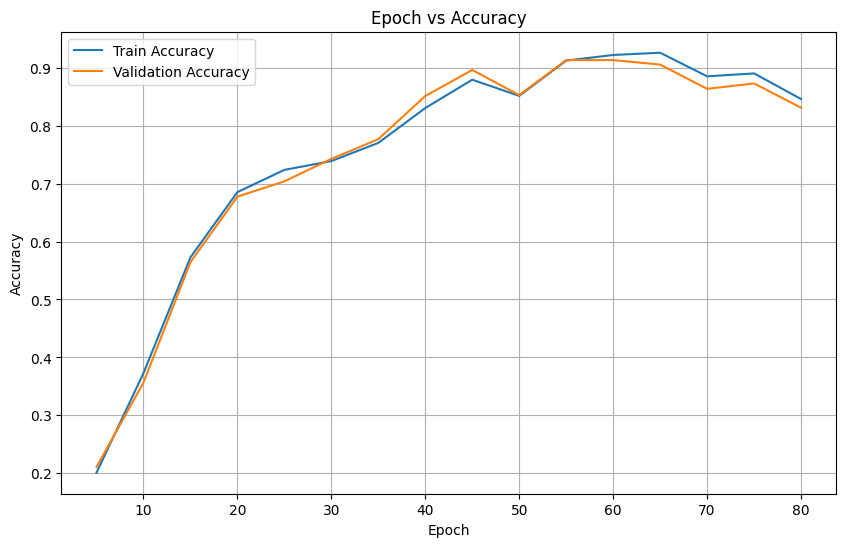

In [141]:
# --- Plotting after training ---

epochs_list = list(range(5, epochs + 1, 5))  # because we log every 5 epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs_list, train_accuracies, label='Train Accuracy')
plt.plot(epochs_list, test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [142]:
test_acc, test_f1_macro, test_f1_weighted = evaluate_f1(model, graph_data, graph_data.test_mask)
print("\nFinal Test Results:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1: {test_f1_macro:.4f}")
print(f"Test Weighted F1: {test_f1_weighted:.4f}")


Final Test Results:
Test Accuracy: 0.8310
Test Macro F1: 0.6500
Test Weighted F1: 0.8013
